In [ ]:
# prompt: auto EDA libraries in python like Sweetviz?
import pandas as pd

# standard libraries
import pandas as pd
import numpy as np
import os
from google.colab import drive
drive.mount('/content/drive')

# ML/stats
from mlxtend.plotting import heatmap
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
# for splitting the data
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import randint
from imblearn.over_sampling import RandomOverSampler
import scipy.stats as ss
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer



# visualizations
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns
import plotly.express as px
from tabulate import tabulate


%matplotlib inline

# tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#for text pre-pricessing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline


#bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec

#google collab drive read data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd

class MetastaticDiagnosis:
    def __init__(self):
        self.train_df = None
        self.test_df = None

    def read_data(self, train_csv, test_csv):
        self.train_df = pd.read_csv(train_csv)
        self.test_df = pd.read_csv(test_csv)
        return self.train_df, self.test_df

    def drop_missing_values(self):
        # Drop missing values
        columns_to_drop = ['bmi', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type']
        self.train_df.drop(columns=columns_to_drop, axis=1, inplace=True)
        self.test_df.drop(columns=columns_to_drop, axis=1, inplace=True)
        return self.train_df, self.test_df

    def load_datasets(self, train_csv, val_csv):
        self.train_df = pd.read_csv(train_csv)
        self.val_df = pd.read_csv(val_csv)
        return self.train_df, self.val_df

    def oversample_data(self):
        if self.train_df is not None:
            # Separate features and target variable
            X = self.train_df.drop(columns=['DiagPeriodL90D'], axis=1)
            y = self.train_df['DiagPeriodL90D']

            # Perform oversampling
            ros = RandomOverSampler(random_state=37)
            X_resampled, y_resampled = ros.fit_resample(X, y)

            # Update the train_df with oversampled data
            self.train_df = pd.concat([X_resampled, y_resampled], axis=1)

            return self.train_df

    def get_column_info(self):
        # Get the datatypes of all columns
        data_types = self.train_df.dtypes
        categorical_cols = data_types[data_types == 'object'].index.tolist()
        categorical_cols = self.train_df.select_dtypes(include=['object', 'category']).columns.tolist()

        # Identify numerical columns
        numerical_cols = data_types[data_types.isin(['int64', 'float64'])].index.tolist()
        numerical_cols = self.train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

        return categorical_cols, numerical_cols

    def impute_data(self):
      if self.train_df is not None:
        categorical_cols, numerical_cols = self.get_column_info()

        columns_to_exclude = ['DiagPeriodL90D', 'patient_id']
        categorical_cols = [col for col in categorical_cols if col not in columns_to_exclude]
        numerical_cols = [col for col in numerical_cols if col not in columns_to_exclude]

        num_imputer = SimpleImputer(strategy='mean')

        cat_imputer = SimpleImputer(strategy='most_frequent')

        if numerical_cols:
            self.train_df[numerical_cols] = num_imputer.fit_transform(self.train_df[numerical_cols])
        if categorical_cols:
            self.train_df[categorical_cols] = cat_imputer.fit_transform(self.train_df[categorical_cols])

        if self.test_df is not None:
            if numerical_cols:
                self.test_df[numerical_cols] = num_imputer.transform(self.test_df[numerical_cols])
            if categorical_cols:
                self.test_df[categorical_cols] = cat_imputer.transform(self.test_df[categorical_cols])

        if self.val_df is not None:
            if numerical_cols:
                self.val_df[numerical_cols] = num_imputer.transform(self.val_df[numerical_cols])
            if categorical_cols:
                self.val_df[categorical_cols] = cat_imputer.transform(self.val_df[categorical_cols])

        return self.train_df, self.test_df, self.val_df


    def find_unseen_categories(self, train_df, val_df, categorical_cols):
        unseen_categories = {}
        for col in categorical_cols:
            train_categories = set(train_df[col].dropna().unique())
            val_categories = set(val_df[col].dropna().unique())

            # Find categories present in validation but not in training
            unseen = val_categories - train_categories

            if unseen:
                unseen_categories[col] = unseen

        return unseen_categories

    def select_top_features(self, df):
        selected_features = [
            "patient_id", "breast_cancer_diagnosis_code","patient_age","metastatic_cancer_diagnosis_code", "breast_cancer_diagnosis_desc",
            "patient_race", "patient_zip3", "payer_type", "patient_state", "Division", "Region","DiagPeriodL90D"
        ]

        return df[selected_features]

    def identify_variable_types(self, dataframe):
        """
        Identifies numerical and categorical variables in the dataframe.

        Parameters:
        - dataframe: A pandas DataFrame.

        Returns:
        - Two lists: one containing numerical variable names and the other containing categorical variable names.
        """
        df_data_types = dataframe.dtypes

        continuous_cols = dataframe.select_dtypes(include=['int64', 'float64']).columns.tolist()

        categorical_cols = dataframe.select_dtypes(include=['object']).columns.tolist()

        if 'patient_zip3' in continuous_cols:
          continuous_cols.remove('patient_zip3')
        if 'patient_zip3' not in categorical_cols:
          categorical_cols.append('patient_zip3')
        return continuous_cols, categorical_cols

    def scale_continuous_features(self, train_df, val_df, continuous_columns, columns_to_exclude):
        # Remove the columns to exclude from the list of continuous columns
        columns_to_scale = [col for col in continuous_columns if col not in columns_to_exclude]

        # Initialize the MinMaxScaler for continuous variables
        scaler = MinMaxScaler((0, 1)).fit(train_df[columns_to_scale])

        # Normalize the continuous variables separately
        train_df[columns_to_scale] = scaler.transform(train_df[columns_to_scale])
        val_df[columns_to_scale] = scaler.transform(val_df[columns_to_scale])

        return train_df, val_df

    def preprocess_data(self, df, train_columns, categorical_columns):
        # One-hot encode the categorical variables
        df_encoded = pd.get_dummies(df, columns=categorical_columns)

        # If train_columns is provided, align the columns
        if train_columns is not None:
            # Add missing columns (that were in training but not in validation) with zeros
            for col in set(train_columns) - set(df_encoded.columns):
                df_encoded[col] = 0

            # Drop extra columns (that are in validation but not in training)
            extra_cols = set(df_encoded.columns) - set(train_columns)
            df_encoded = df_encoded.drop(columns=extra_cols, errors='ignore')

            # Reorder columns to match the training data
            df_encoded = df_encoded.reindex(columns=train_columns, fill_value=0)

        return df_encoded

    def preprocess_and_shuffle(self, df, target_column, is_fit=False):
        """
        Preprocesses the given dataframe, shuffles the data, and separates the target variable.

        Args:
        df (DataFrame): The DataFrame containing the text data and other features.
        target_column (str): The name of the target column.
        is_fit (bool): If True, fit the preprocessor on the data.

        Returns:
        ndarray: An array of processed and shuffled features.
        Series: The shuffled target variable.
        """
        # Keep this column for submission
        patient_id = df['patient_id'].values

        # Select all columns except the target column and 'breast_cancer_diagnosis_desc'
        features = df.drop(columns=['patient_id', target_column])

        # Shuffle the data
        processed_features, target = shuffle(features, df[target_column], random_state=42)

        return processed_features, target, patient_id


# Define file paths for training and testing data
train_csv_path = '/content/drive/MyDrive/WIDS-Datathon-2024/Data/Train/'
test_csv_path = '/content/drive/MyDrive/WIDS-Datathon-2024/Data/Test/'

train_split_path = '/content/drive/MyDrive/WIDS-Datathon-2024/split/train_set.csv'
val_split_path = '/content/drive/MyDrive/WIDS-Datathon-2024/split/val_set.csv'


# Create an instance of the class
meta_obj = MetastaticDiagnosis()

# Call the read_data function
train_csv = train_csv_path + 'training.csv'
test_csv = test_csv_path + 'test.csv'
train_df, test_df = meta_obj.read_data(train_csv, test_csv)
print("Train data shape :", train_df.shape)
print("Test data shape:", test_df.shape, "\n")

# Call the drop_missing_values function
train_df, test_df = meta_obj.drop_missing_values()
print("Train data shape after dropping columns:", train_df.shape)
print("Test data shape after dropping columns:", test_df.shape, "\n")

# Call the load_datasets function train and validation from drive
train_df, val_df = meta_obj.load_datasets(train_split_path, val_split_path)
print("Train data shape :", train_df.shape)
print("Validation data shape:", val_df.shape, "\n")

# Call the oversample_data function
train_df = meta_obj.oversample_data()
print("Train data shape after oversampling columns:", train_df.shape, "\n")

#Identify the categorical and the numerical columns
categorical_cols, numerical_cols = meta_obj.get_column_info()
print("categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols, "\n")


# Call the impute_data function
train_df, test_df, val_df = meta_obj.impute_data()
print("Train data shape after imputation:", train_df.shape)
print("Test data shape after imputation:", test_df.shape)
print("Validation data shape after imputation:", val_df.shape, "\n")


# Call the find_unseen_categories function
categorical_cols, _ = meta_obj.get_column_info()

unseen_categories_in_val = meta_obj.find_unseen_categories(train_df, val_df, categorical_cols)
print("Unseen categories in validation:", unseen_categories_in_val, "\n")


# Call the select_top_features function
train_df_selected = meta_obj.select_top_features(train_df)
val_df_selected = meta_obj.select_top_features(val_df)
print("Train data shape after feature selection:", train_df_selected.shape)
print("Validation data shape after feature selection:", val_df_selected.shape,"\n")



# Call the identify_variable_types function
continuous_cols, category_cols = meta_obj.identify_variable_types(train_df_selected)
print(train_df_selected.columns)
print("Continuous columns:", continuous_cols)
print("Categorical columns:", category_cols,"\n")



continuous_cols_to_exclude = ['patient_id', 'DiagPeriodL90D']
train_df_scaled, val_df_scaled = meta_obj.scale_continuous_features(train_df_selected, val_df_selected, continuous_cols, continuous_cols_to_exclude)
print("After scaling train data ",train_df_scaled.shape)
print("After scaling val data", val_df_scaled.shape, "\n")


# Apply preprocessing to the training dataset
train_df_encoded = meta_obj.preprocess_data(train_df_scaled, None, category_cols)

# Get the list of columns from the transformed training dataset
train_columns = train_df_encoded.columns.tolist()

# Apply preprocessing to the validation dataset, aligning it to the training columns
val_df_encoded = meta_obj.preprocess_data(val_df_scaled, train_columns, category_cols)

# Now both datasets should have the same shape
print("Train data shape after one hot encoding: ", train_df_encoded.shape)
print("Validation data shape after one hot encoding: ", val_df_encoded.shape, "\n")


# Fit on train data and transform train data
X_train, y_train, train_patient_id = meta_obj.preprocess_and_shuffle(train_df_encoded, 'DiagPeriodL90D', is_fit=True)

# Transform validation data
X_val, y_val, val_patient_id = meta_obj.preprocess_and_shuffle(val_df_encoded, 'DiagPeriodL90D', is_fit=False)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape, "\n")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/WIDS-Datathon-2024/Data/Train/training.csv'

Training Classification Report:
                               precision    recall  f1-score   support

Not Diagnosed within 90 Days       0.94      0.56      0.71      6448
    Diagnosed within 90 Days       0.69      0.97      0.80      6448

                    accuracy                           0.76     12896
                   macro avg       0.82      0.76      0.75     12896
                weighted avg       0.82      0.76      0.75     12896



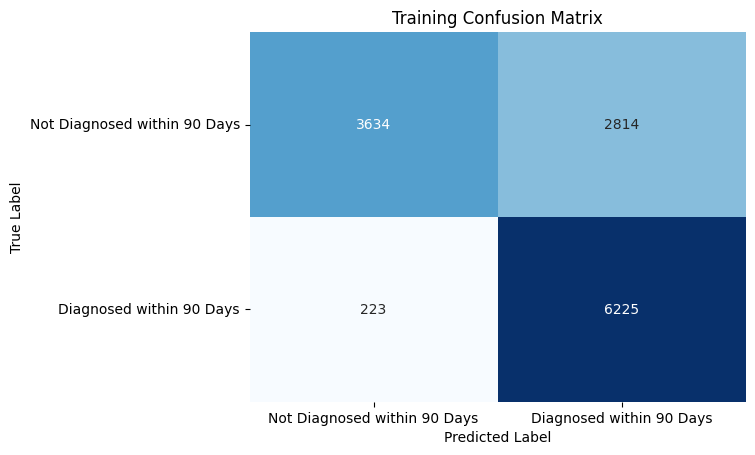

Validation Classification Report:
                               precision    recall  f1-score   support

Not Diagnosed within 90 Days       0.90      0.55      0.68       970
    Diagnosed within 90 Days       0.78      0.96      0.86      1612

                    accuracy                           0.81      2582
                   macro avg       0.84      0.75      0.77      2582
                weighted avg       0.82      0.81      0.79      2582



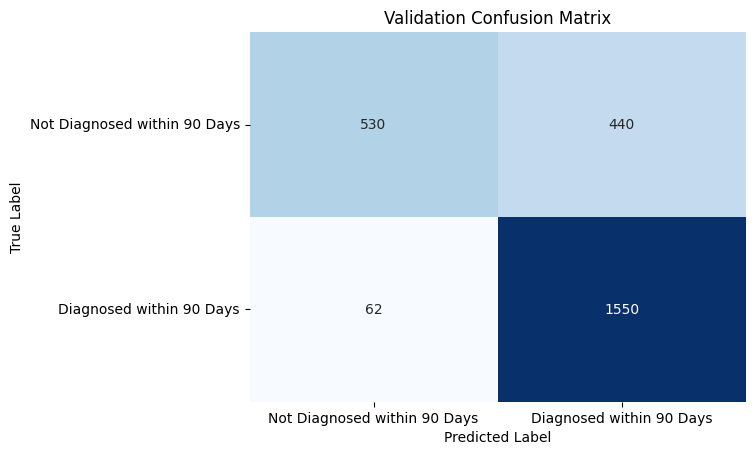


 ROC Curve


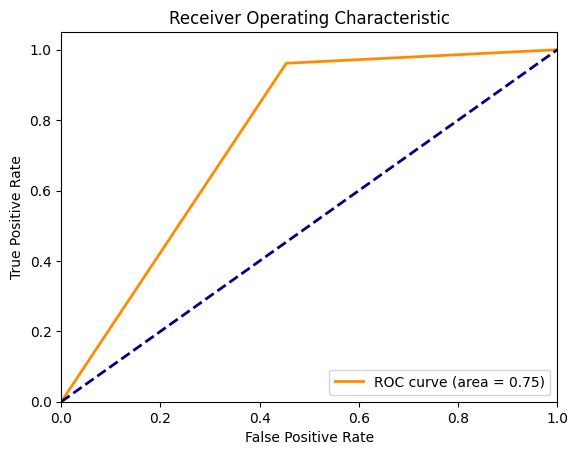

In [ ]:

class ModelBuilder:
    def __init__(self):
        self.rf_classifier = None

    def build_random_forest(self):
        param_dist = {
            'n_estimators': randint(50, 500),
            'max_depth': randint(1, 20)
        }

        # Create a random forest classifier
        rf_classifier = RandomForestClassifier(n_estimators=100,  # You might not need to change this
                                               criterion='gini',
                                               max_depth=10,  # Limit the depth of trees
                                               min_samples_split=10,  # Increase the minimum number of samples for a split
                                               min_samples_leaf=4,  # Increase the minimum number of samples in leaf nodes
                                               max_features='sqrt',  # Consider fewer features at each split
                                               bootstrap=True,
                                               random_state=42)

        self.rf_classifier = rf_classifier

    def train(self, X_train, y_train):
        if self.rf_classifier is not None:
            self.rf_classifier.fit(X_train, y_train)
        else:
            raise ValueError("Model has not been built yet.")
        return self.rf_classifier

    def generate_submission(self, X_val, y_val, val_patient_id, result_path):
        if self.rf_classifier is None:
            raise ValueError("Model has not been built yet.")

        # Generate estimates for validation data
        val_yhat_probs_sub = self.rf_classifier.predict_proba(X_val)

        # Create the submission DataFrame with probability scores
        submission = pd.DataFrame({
            'patient_id': val_patient_id,
            'DiagPeriodL90D': y_val,  # True target values
            'prediction_probability': val_yhat_probs_sub[:, 1]  # Probability of the positive class
        })

        # Save the submission DataFrame to a CSV file
        submission.to_csv(result_path + '2b_random_forest_submission.csv', index=False)

    def calculate_training_classification_report(self, y_train, train_yhat_probs,classes):
        report = classification_report(y_train, train_yhat_probs, target_names=classes)
        return report

    def plot_training_confusion_matrix(self, y_train, train_yhat_probs, classes):
        train_cm = confusion_matrix(y_train, train_yhat_probs)
        ax = sns.heatmap(train_cm,
                         annot=True,
                         fmt='.0f',
                         cmap='Blues',
                         xticklabels=classes,
                         yticklabels=classes,
                         cbar=False)
        ax.set(xlabel='Predicted Label', ylabel='True Label')
        plt.title('Training Confusion Matrix')
        plt.show()

    def calculate_validation_classification_report(self, y_val, val_yhat_probs, classes):
        report = classification_report(y_val, val_yhat_probs, target_names=classes)
        return report

    def plot_validation_confusion_matrix(self, y_val, val_yhat_probs, classes):
        val_cm = confusion_matrix(y_val, val_yhat_probs)
        ax = sns.heatmap(val_cm,
                         annot=True,
                         fmt='.0f',
                         cmap='Blues',
                         xticklabels=classes,
                         yticklabels=classes,
                         cbar=False)
        ax.set(xlabel='Predicted Label', ylabel='True Label')
        plt.title('Validation Confusion Matrix')
        plt.show()

    def plot_roc_curve(self, y_true, y_scores):
      """
      Plot the Receiver Operating Characteristic (ROC) curve.

      Args:
      y_true (array-like): True binary labels.
      y_scores (array-like): Target scores, can either be probability estimates of the positive class or confidence values.

      Returns:
      None (displays the ROC curve plot).
      """
      fpr, tpr, _ = roc_curve(y_true, y_scores)
      roc_auc = auc(fpr, tpr)

      plt.figure()
      plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
      plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Receiver Operating Characteristic')
      plt.legend(loc="lower right")
      plt.show()



# Create an instance of the ModelBuilder class
model_trainer = ModelBuilder()

# Build the random forest classifier
model_trainer.build_random_forest()

# Train the random forest classifier
rf_classifier = model_trainer.train(X_train, y_train)

#submission
result_path = '/content/drive/MyDrive/HS/'
model_trainer.generate_submission(X_val, y_val, val_patient_id, result_path)


# Calculate the training classification report
train_yhat_probs = rf_classifier.predict(X_train)
val_yhat_probs = rf_classifier.predict(X_val)

classes = ["Not Diagnosed within 90 Days", "Diagnosed within 90 Days"]


train_classification_report = model_trainer.calculate_training_classification_report(y_train, train_yhat_probs,classes)
print("Training Classification Report:\n", train_classification_report)

# Plot the training confusion matrix
model_trainer.plot_training_confusion_matrix(y_train, train_yhat_probs,classes)


val_classification_report = model_trainer.calculate_validation_classification_report(y_val, val_yhat_probs,classes)
print("Validation Classification Report:\n", val_classification_report)

# Plot the Validation confusion matrix
model_trainer.plot_validation_confusion_matrix(y_val, val_yhat_probs,classes)

print("\n ROC Curve")
#plot ROC Curve
y_true = y_val
y_scores = val_yhat_probs
model_trainer.plot_roc_curve(y_true, y_scores)